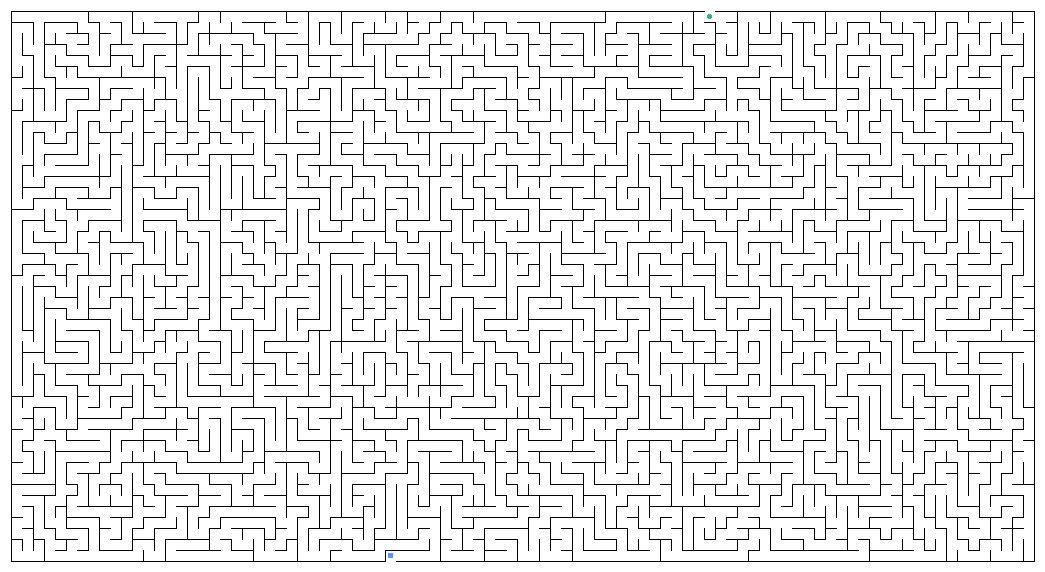

In [1]:
from IPython.display import Image, display
import cv2 

def load_image(file_path):
    """Load an image from file."""
    return cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

# Load image from file as Image object and numpy array
img_array = load_image("maze_example/maze_1.png")
img_rgb = Image(filename="maze_example/maze_1.png")

display(img_rgb)

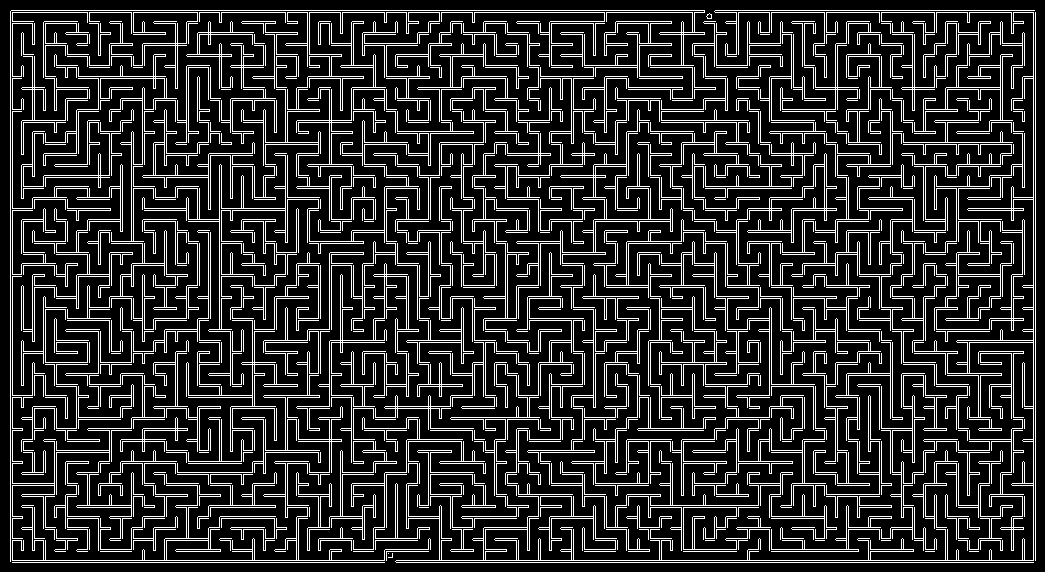

In [2]:
from PIL import Image
import numpy as np

def detect_edges(image, low_threshold=50, high_threshold=150):
    """Detect edges in an image using the Canny algorithm."""
    return cv2.Canny(image, low_threshold, high_threshold)

# Test the function
edges = detect_edges(img_array)

# Convert the numpy array to a PIL image
edges_img = Image.fromarray(edges)

# Display the image
display(edges_img)

In [3]:
import numpy as np

def find_cell_size_and_count(edges):
    # Find the indices of the first edge pixel in the image
    edge_indices = np.where(edges == 255)
  
    # The cell size is the minimum of the row and column indices + 1
    cell_size = min(edge_indices[0][0], edge_indices[1][0]) + 1

    # Calculate the image size
    height, width = edges.shape

    # Calculate cell count in width and height
    width_cell_count = (width - 2 * cell_size) // cell_size
    height_cell_count = (height - 2 * cell_size) // cell_size

    return cell_size, width_cell_count, height_cell_count

# Test the function
cell_size, width_cell_count, height_cell_count = find_cell_size_and_count(edges)
print(f'Cell Size: {cell_size}')
print(f'Width Cell Count: {width_cell_count}')
print(f'Height Cell Count: {height_cell_count}')

Cell Size: 11
Width Cell Count: 93
Height Cell Count: 50


In [4]:
def remove_padding(edges, cell_size):
    start_row = cell_size - 1
    end_row = edges.shape[0] - cell_size
    start_col = cell_size + 1
    end_col = edges.shape[1] - cell_size 
    return edges[start_row:end_row, start_col:end_col]

# Call the function
edges = remove_padding(edges, cell_size)

In [5]:
from preprocess.cell import Cell 

def edges_to_cells(edges, cell_size, width_cell_count, height_cell_count):
    # Initialize a 2D grid of cells
    grid = [[Cell(x, y) for x in range(width_cell_count)] for y in range(height_cell_count)]
    
    # Assuming 70% 255's is considered a wall
    threshold = 0.7 * cell_size

    # Iterate through the grid
    for i in range(height_cell_count):
        for j in range(width_cell_count):
            # Avoid out-of-bound indices
            i_next = min((i+1)*cell_size, edges.shape[0]-1)
            j_next = min((j+1)*cell_size, edges.shape[1]-1)
            
            # Get the corresponding cell borders from edges
            top = edges[i*cell_size, j*cell_size:j_next]
            bottom = edges[i_next, j*cell_size:j_next]
            left = edges[i*cell_size:i_next, j*cell_size]
            right = edges[i*cell_size:i_next, j_next]
            
            cell = grid[i][j]
            
            # Set wall attributes based on edge data
            cell.walls['top'] = np.sum(top == 255) >= threshold
            cell.walls['bottom'] = np.sum(bottom == 255) >= threshold
            cell.walls['left'] = np.sum(left == 255) >= threshold
            cell.walls['right'] = np.sum(right == 255) >= threshold

            grid[i][j] = cell
    return grid

pygame 2.5.0 (SDL 2.28.0, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
grid = edges_to_cells(edges, cell_size, width_cell_count, height_cell_count)

In [7]:
def find_start_end(grid):
    """
    Finds the start and end cells in the grid based on missing walls.

    Parameters:
    grid (list): The 2D grid representing the maze.

    Returns:
    start (Cell), end (Cell): The start and end cells in the maze, or None if not found.
    """
    height = len(grid)
    width = len(grid[0])

    # Check top and bottom borders
    for i in range(width):
        if not grid[0][i].walls['top']:
            start = grid[0][i]
            grid[0][i].status = 'start'
        if not grid[height-1][i].walls['bottom']:
            end = grid[height-1][i]
            grid[height-1][i].status = 'end'

    # Check left and right borders
    for i in range(height):
        if not grid[i][0].walls['left']:
            start = grid[i][0]
            grid[i][0].status = 'start'
        if not grid[i][width-1].walls['right']:
            end = grid[i][width-1]
            grid[i][width-1].status = 'end'

    return start, end

In [8]:
from preprocess.draw import draw_maze
from preprocess.a_star import a_star_visualization

start, end = find_start_end(grid)

# Find the shortest path
shortest_path = a_star_visualization(grid, start, end, width_cell_count, height_cell_count, cell_size)
print(f"shortest path length {len(shortest_path)}")

shortest path length 711


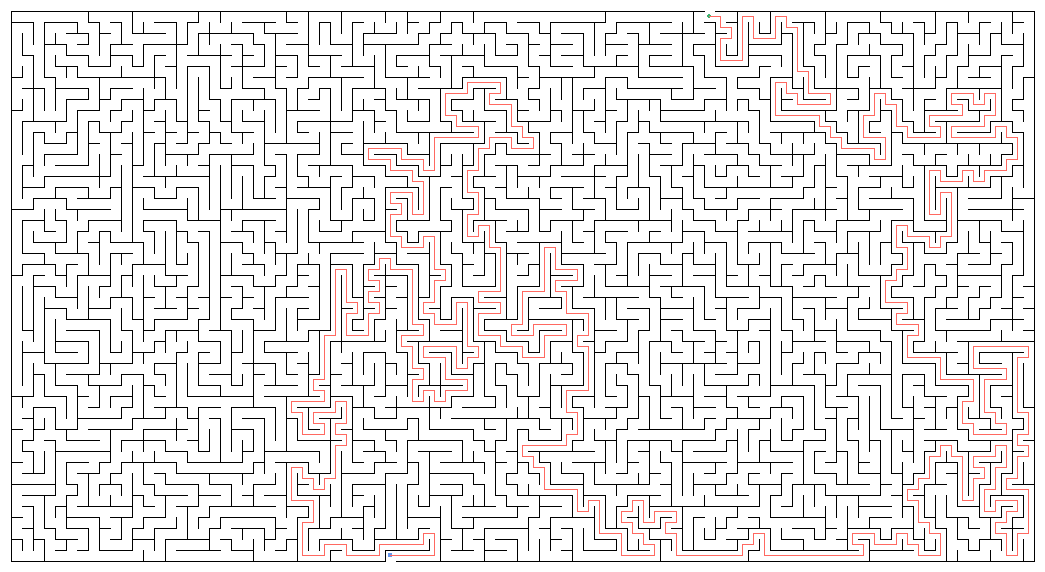

In [9]:
from IPython.display import Image, display
from preprocess.draw import draw_maze

# Draw the maze image with the shortest path
draw_maze(grid, start, end, path=shortest_path, filename="maze_example/maze_solution.png", cell_size=cell_size)

# Load image from file
img = Image(filename="maze_example/maze_solution.png")

# Display the image
display(img)